In [1]:
# Set this variable to directory containing CONET executable
bin_dir = './'

import networkx as nx
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

from conet import CorrectedCounts, DataConverter, CONET, CONETParameters, InferenceResult

In [2]:
# These counts are restricted to chromosomes 17, 18, 20, 23 to speed up computations
corrected_counts_df =  pd.read_csv("data/SA501X3F_filtered_corrected_counts_chr_17_18_20_23.csv", sep=',', header=0, low_memory=False)

In [3]:
corrected_counts_df.head()

,chr,start,end,width,candidate_brkp,SA501X3F.00136,SA501X3F.00268,SA501X3F.00324,SA501X3F.00164,SA501X3F.00143,...,SA501X3F.00038,SA501X3F.00103,SA501X3F.00156,SA501X3F.00357,SA501X3F.00314,SA501X3F.00344,SA501X3F.00194,SA501X3F.00302,SA501X3F.00300,SA501X3F.00375
0,17,1,150000,150000,1,0.810188,1.025780,0.908057,1.530923,0.842768,...,0.753541,1.026763,0.845121,0.986346,1.023848,0.722363,1.050178,1.080856,0.671242,0.948864
1,17,450001,600000,150000,1,0.852210,0.872722,0.624927,0.973214,0.503442,...,1.055211,1.151526,0.759393,1.323128,0.677212,1.498665,0.891943,0.736687,0.653061,0.766305
2,17,600001,750000,150000,1,0.780638,0.691622,0.790678,1.064621,0.936910,...,1.136267,0.868814,0.935041,0.805236,1.304585,1.453218,1.570253,1.226569,0.629264,1.824633
3,17,750001,900000,150000,1,0.950505,0.861479,0.756719,0.904817,0.655482,...,0.665281,0.997353,1.018403,0.672956,0.918989,0.715717,1.070443,0.860923,0.847082,0.818582
4,17,900001,1050000,150000,0,1.144299,1.018131,0.845542,0.917654,0.935365,...,1.071978,0.753864,0.843184,1.171302,1.233414,0.861486,1.308334,1.000605,0.814934,1.400365


In [4]:
cc = CorrectedCounts(corrected_counts_df)
# Add artifical bins to enable chromosome-wide events
cc.add_chromosome_ends(neutral_cn=2, end_bin_length=150000)
# convert corrected counts to input files for CONET.
DataConverter(event_length_normalizer=3095677412).create_CoNET_input_files(bin_dir, corrected_counts=cc)

In [5]:
# this may take up to 10 minutes
conet = CONET(bin_dir + "CONET")
params = CONETParameters(tree_structure_prior_k1 = 0.5, data_dir = bin_dir, counts_penalty_s1=200000, counts_penalty_s2=200000,
                            param_inf_iters=30000, seed = 21567, mixture_size=2, pt_inf_iters=200000, neutral_cn =2, output_dir = "./output/")
conet.infer_tree(params)

Calling CONET executable with args: [('--data_dir', './'), ('--param_inf_iters', '30000'), ('--pt_inf_iters', '200000'), ('--counts_penalty_s1', '200000'), ('--counts_penalty_s2', '200000'), ('--event_length_penalty_k0', '1.0'), ('--tree_structure_prior_k1', '0.5'), ('--use_event_lengths_in_attachment', 'True'), ('--seed', '21567'), ('--mixture_size', '2'), ('--num_replicas', '5'), ('--threads_likelihood', '4'), ('--verbose', 'True'), ('--neutral_cn', '2'), ('--output_dir', './output/')]
2022-07-05 10:15:10,844 — conet.conet — INFO — CONET log: b'Input files have been loaded successfully\n'
2022-07-05 10:15:17,083 — conet.conet — INFO — CONET log: b'Starting parameter MCMC estimation...\n'
2022-07-05 10:15:58,152 — conet.conet — INFO — CONET log: b'Finished parameter estimation\n'
2022-07-05 10:15:58,153 — conet.conet — INFO — CONET log: b'Estimated breakpoint distribution: (weight: 1 mean: 0.00331643sd: 1.1385)\n'
2022-07-05 10:15:58,154 — conet.conet — INFO — CONET log: b'\n'
2022-07

In [6]:
result = InferenceResult('./output/', cc)

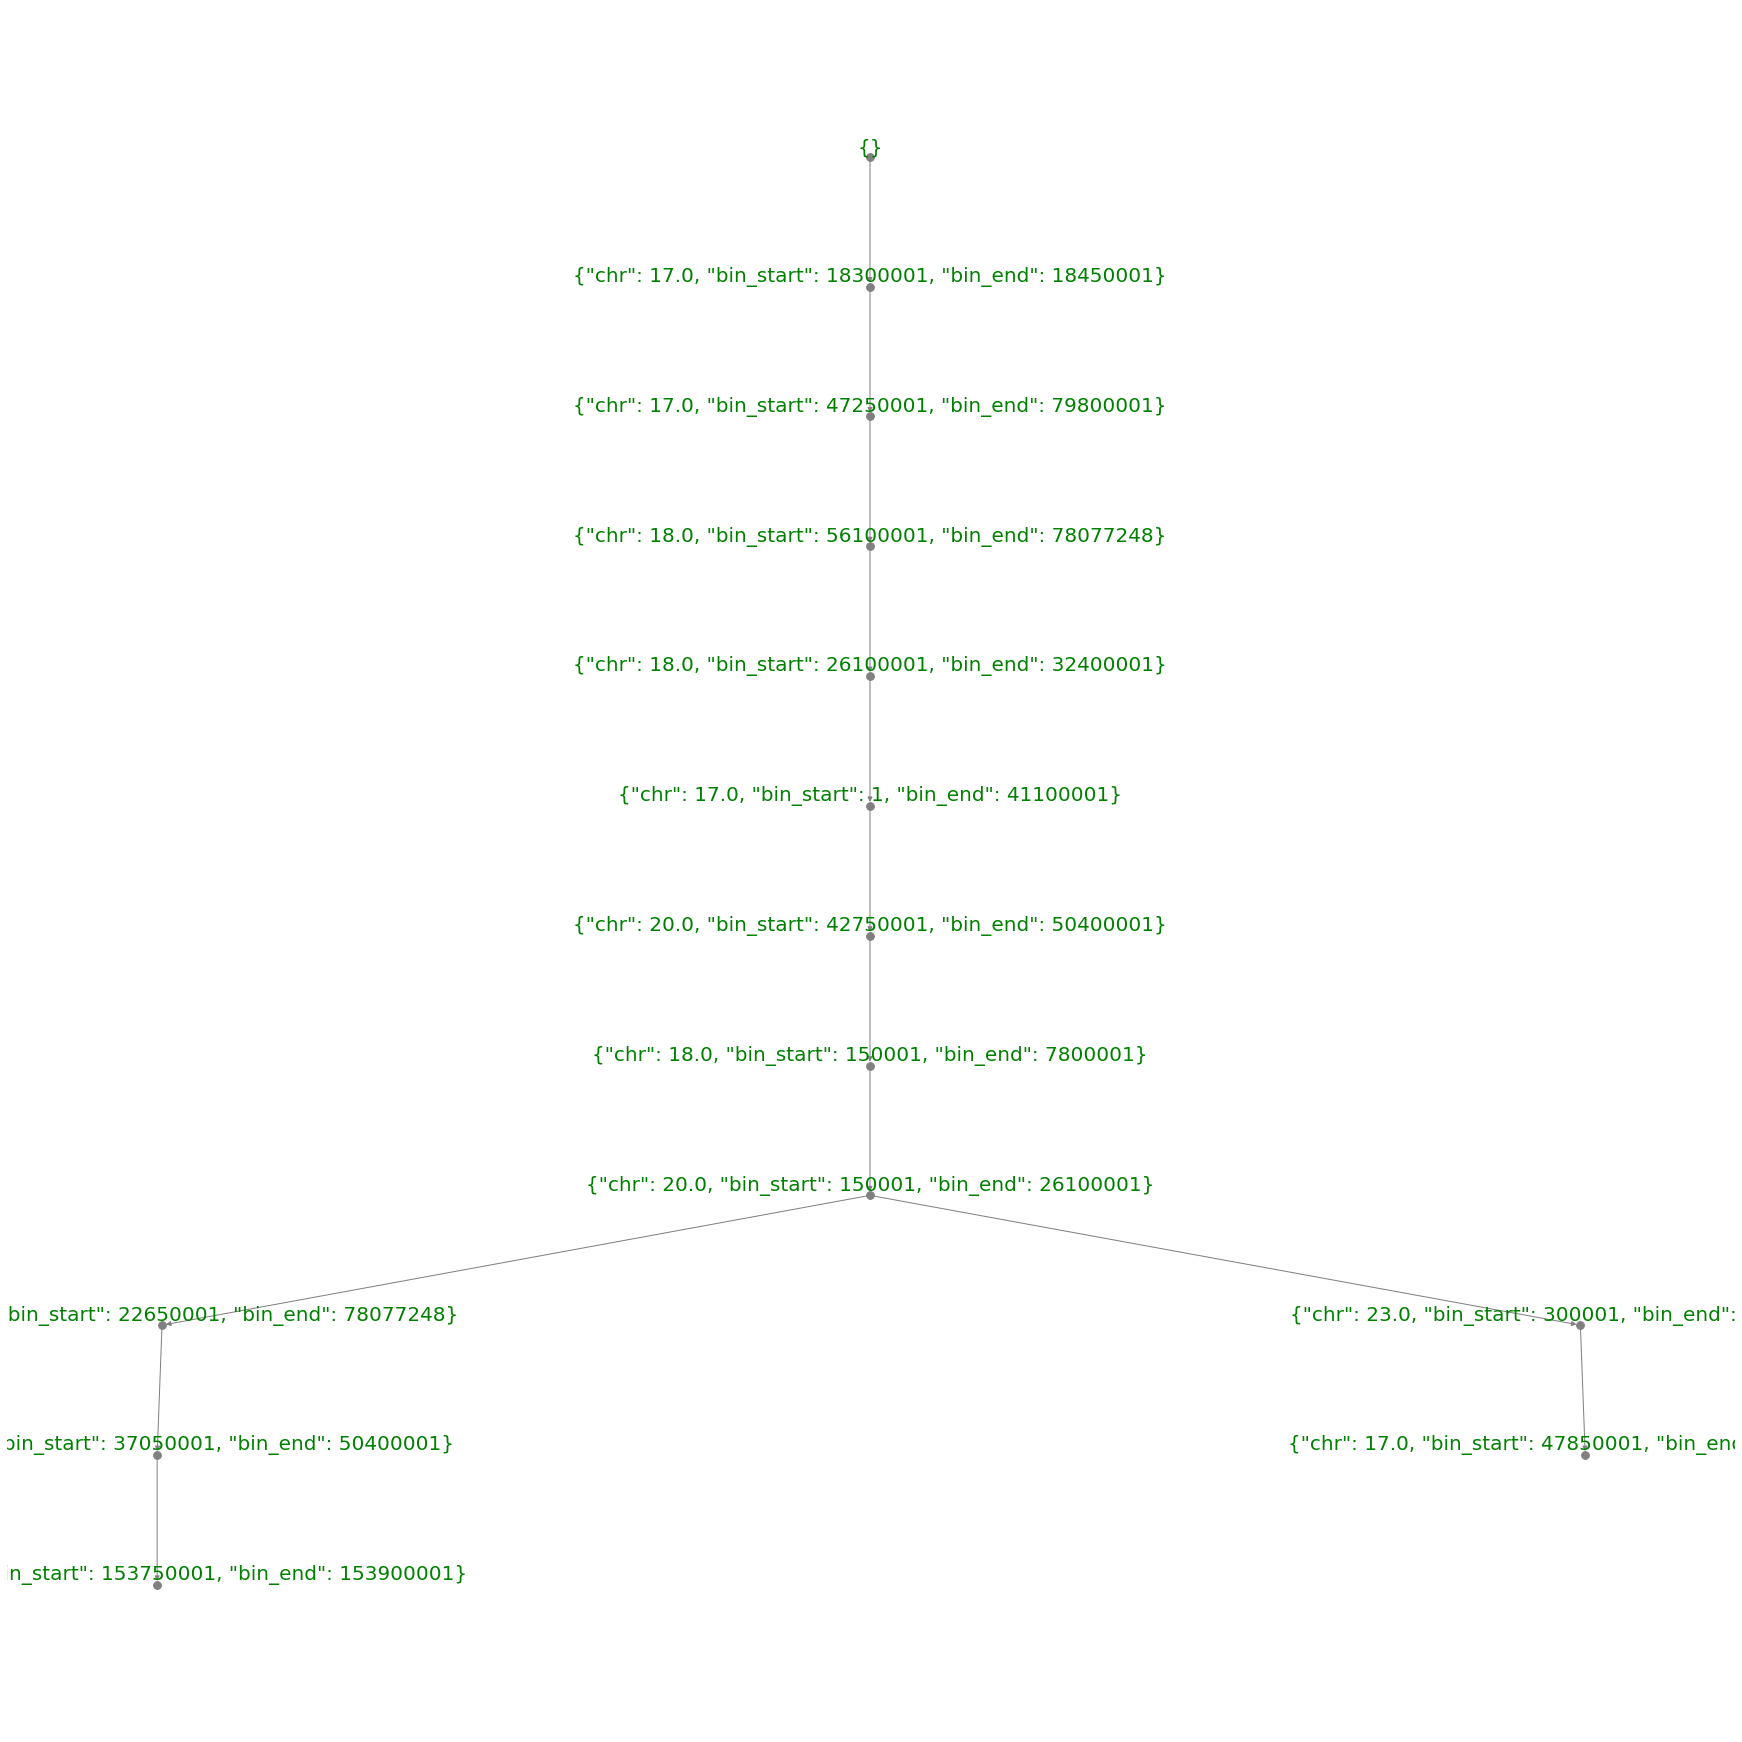

In [7]:
# Draw inferred tree 
plt.figure(3, figsize=(24, 24))
pos = graphviz_layout(result.inferred_tree, prog="dot")
nx.draw(result.inferred_tree, pos=pos, with_labels=True, node_color="grey", node_size=60, verticalalignment="bottom",
        font_size=20, edge_color="grey", font_color="green")
plt.show()

In [8]:
# Get estimated copy number profiles  
inferred_counts = np.transpose(result.get_inferred_copy_numbers(neutral_cn=2))

In [9]:
attachment = result.attachment
# cell number (cells are numbered from 0 in the order given by CC matrix) 10 is attached to:
attachment[10]

{'chr': 23.0, 'bin_start': 300001, 'bin_end': 155270560}

In [10]:
# Save results in format expected by R scripts
result.dump_results_to_dir("./output",neutral_cn=2)